In [1]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_squared_error
from autogluon.tabular import TabularPredictor
from autogluon.multimodal import MultiModalPredictor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [2]:
import numpy as np

In [3]:
import autogluon.eda.analysis as eda
import autogluon.eda.visualization as viz
import autogluon.eda.auto as auto

In [2]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0

True
1


In [28]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [2]:
df_c19 = pd.read_csv("final_datasets/c19_final_2.csv")
df_m17 = pd.read_csv("final_datasets/m17_final_2.csv")
df_c19 = df_c19.sample(n=len(df_c19), random_state=42)
df_m17 = df_m17.sample(n=len(df_m17), random_state=42)

In [3]:
def get_train_test(df, text = False):
    df.drop(['science_field', 'collaborators', 'journal_name'], axis = 1, inplace= True, errors='ignore')
    enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
    df['rigor'] = enc.fit_transform(df[['rigor']])
    df['novelty'] = enc.fit_transform(df[['novelty']])
    df['accessibility'] = enc.fit_transform(df[['accessibility']])
    # df_c19[['rigor', 'novelty', 'accessibility']] = df_c19[['rigor', 'novelty', 'accessibility']].astype('category')
    # enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
    # df['rigor'] = enc.fit_transform(df[['rigor']])
    # df['novelty'] = enc.fit_transform(df[['novelty']])
    # df['accessibility'] = enc.fit_transform(df[['accessibility']])
    if 'evaluation' in df.columns:
        if text:
            df = df[['evaluation', 'abstract', 'title']]
        y  = df['evaluation']
    else:
        if text:
            df = df[['cited', 'abstract', 'title']]
        y  = df['cited']
        
    X =  df.drop(['cited', 'evaluation'], axis=1, errors='ignore')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train['label'] = y_train
    return  X_train, X_test, y_test

In [4]:
def get_conf_matrix(y_test, y_pred):
    intensity = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=set(y_test))
    disp.plot()

In [5]:
X_train_m17, X_test_m17, y_test_m17 = get_train_test(df_m17)
X_train_c19, X_test_c19, y_test_c19 = get_train_test(df_c19)

In [6]:
def train_multimodal(X_train, X_test, y_test):
    predictor = TabularPredictor(label='label')
    predictor.fit(X_train, hyperparameters = 'multimodal')
    y_pred = predictor.predict(X_test)

    # if task == 'classification': 
    display("Task: Classification")
    display(f"Multimodal Predictor Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Multimodal Predictor Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Multimodal Predictor F1 score: {f1_score(y_test, y_pred, average='macro')}")
    display(f"Multimodal Predictor Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Multimodal Predictor MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Multimodal Predictor MSE score: {mean_squared_error(y_test, y_pred)}")
    display(f"Multimodal Predictor RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    # else:
    #     display("Task: Regression")
    #     display(f"Multimodal Predictor MAE score before roudning: {mean_absolute_error(y_test, y_pred)}")
    #     y_pred = [round(val) for val in y_pred]
    #     display(f"Multimodal Predictor Accuracy score: {accuracy_score(y_test, y_pred)}")
    #     display(f"Multimodal Predictor Recall score: {recall_score(y_test, y_pred, average='macro')}")
    #     display(f"Multimodal Predictor F1 score: {f1_score(y_test, y_pred, average='macro')}")
    #     display(f"Multimodal Predictor Precision score: {precision_score(y_test, y_pred, average='macro')}")
    #     display(f"Multimodal Predictor MAE score: {mean_absolute_error(y_test, y_pred)}")
    #     display(f"Multimodal Predictor MSE score: {mean_squared_error(y_test, y_pred)}")
    #     display(f"Multimodal Predictor RMSE score: {root_mean_squared_error(y_test, y_pred)}")
        
    get_conf_matrix(y_test, y_pred)
    X_test['label'] = y_test
    predictor.feature_importance(X_test)
    return predictor

In [34]:
X_train_c19

,title,abstract,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,physical_sciences,...,focus_groups,interviews,mixed_methods,observation,qualitative_research,quantitative_research,questionnaires,secondary_research,survey_methodology,label
545,Educational gains of in‐person vs. distance le...,Using data from a computer‐based formative fee...,2.0,2.0,0,1,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
624,Emetine suppresses SARS-CoV-2 replication by i...,Emetine is a FDA-approved drug for the treatme...,2.0,2.0,0,1,2.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2739,Gynecological laparoscopic surgery in the shad...,A global public health problem with a high rat...,1.0,0.0,0,0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2786,Infections on the move: how transient phases o...,Animal movement impacts the spread of human an...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,1
394,A New Method of Differentiation Between a Biol...,The main obstacle in identifying a biological ...,1.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,Impacts of SARS on health-seeking behaviors in...,BACKGROUND. The severe acute respiratory syndr...,1.0,2.0,0,1,2.0,1.0,1.0,1.0,...,0,0,1,0,1,0,0,0,1,1
2078,Exercise-induced immune system response: Anti-...,Abstract A wide array of molecular pathways ha...,1.0,2.0,0,1,2.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
890,SOFIA(®)RSV: prospective laboratory evaluation...,BACKGROUND: Respiratory syncytial virus (RSV) ...,2.0,2.0,0,1,2.0,0.0,0.0,0.0,...,0,0,1,0,1,1,0,0,0,0
2517,Rapid response in the COVID-19 pandemic: a Del...,BACKGROUND: COVID-19 was declared a global hea...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,1


### Run CORD-19 Multimodal model
abstract text + title text + generated features

No path specified. Models will be saved in: "AutogluonModels\ag-20240620_144309"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240620_144309"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

'Task: Classification'

'Multimodal Predictor Accuracy score: 0.665'

'Multimodal Predictor Recall score: 0.6679950061865323'

'Multimodal Predictor F1 score: 0.6649246080368083'

'Multimodal Predictor Precision score: 0.6687228516412163'

'Multimodal Predictor MAE score: 0.335'

'Multimodal Predictor MSE score: 0.335'

'Multimodal Predictor RMSE score: 0.5787918451395113'

Computing feature importance via permutation shuffling for 64 features using 600 rows with 5 shuffle sets...
	229.96s	= Expected runtime (45.99s per shuffle set)

KeyboardInterrupt



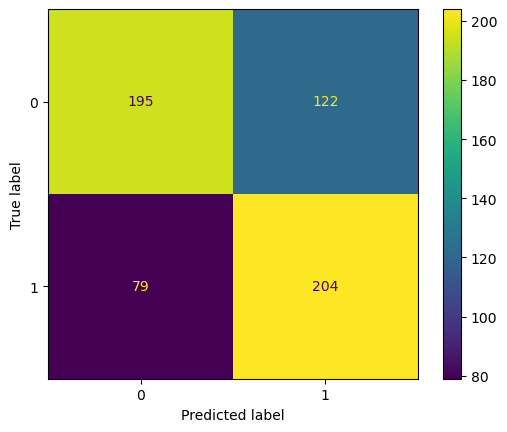

In [37]:
train_multimodal(X_train_c19, X_test_c19, y_test_c19)

In [19]:
train_multimodal(X_train_c19[['abstract', 'label']], pd.DataFrame(X_train_c19['abstract']), y_test_c19, 'binary')

No path specified. Models will be saved in: "AutogluonModels\ag-20240616_201629"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240616_201629"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

Predicting: 0it [00:00, ?it/s]

'Task: Regression'

ValueError: Found input variables with inconsistent numbers of samples: [600, 2398]

In [20]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240616_201629")
y_pred = predictor.predict(X_test_c19)
y_test = y_test_c19
display("Task: Classification")
display(f"Multimodal Predictor Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multimodal Predictor Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multimodal Predictor F1 score: {f1_score(y_test, y_pred, average='macro')}")
display(f"Multimodal Predictor Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multimodal Predictor MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multimodal Predictor MSE score: {mean_squared_error(y_test, y_pred)}")
display(f"Multimodal Predictor RMSE score: {root_mean_squared_error(y_test, y_pred)}")

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_201629\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

'Task: Classification'

'Multimodal Predictor Accuracy score: 0.63'

'Multimodal Predictor Recall score: 0.6360089621116698'

'Multimodal Predictor F1 score: 0.628178072555522'

'Multimodal Predictor Precision score: 0.6410268264774212'

'Multimodal Predictor MAE score: 0.37'

'Multimodal Predictor MSE score: 0.37'

'Multimodal Predictor RMSE score: 0.6082762530298219'

No path specified. Models will be saved in: "AutogluonModels\ag-20240616_170325"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240616_170325"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

Predicting: 0it [00:00, ?it/s]

'Task: Regression'

'Multimodal Predictor MAE score before roudning: 0.43731759549429017'

'Multimodal Predictor Accuracy score: 0.645'

'Multimodal Predictor Recall score: 0.6507730378660366'

'Multimodal Predictor F1 score: 0.64349376114082'

'Multimodal Predictor Precision score: 0.6557146804199668'

'Multimodal Predictor MAE score: 0.355'

'Multimodal Predictor MSE score: 0.355'

'Multimodal Predictor RMSE score: 0.5958187643906492'

None

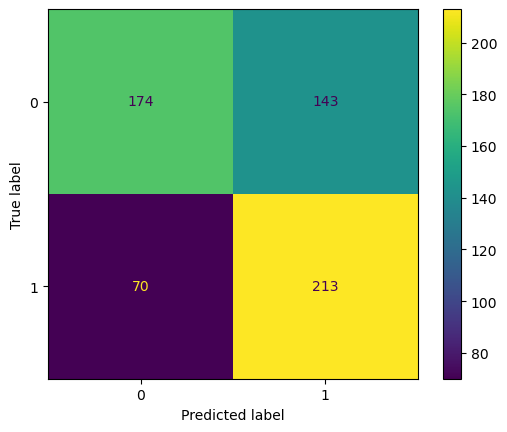

In [10]:
train_multimodal(X_train_c19, X_test_c19, y_test_c19, 'regression')

No path specified. Models will be saved in: "AutogluonModels\ag-20240616_200553"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240616_200553"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

Predicting: 0it [00:00, ?it/s]

'Task: Regression'

'Multimodal Predictor MAE score before roudning: 1.0075'

'Multimodal Predictor Accuracy score: 0.3775'

'Multimodal Predictor Recall score: 0.3693050262021667'

'Multimodal Predictor F1 score: 0.32494219076875935'

'Multimodal Predictor Precision score: 0.3312208725886968'

'Multimodal Predictor MAE score: 1.0075'

'Multimodal Predictor MSE score: 2.0975'

'Multimodal Predictor RMSE score: 1.448274835796024'

None

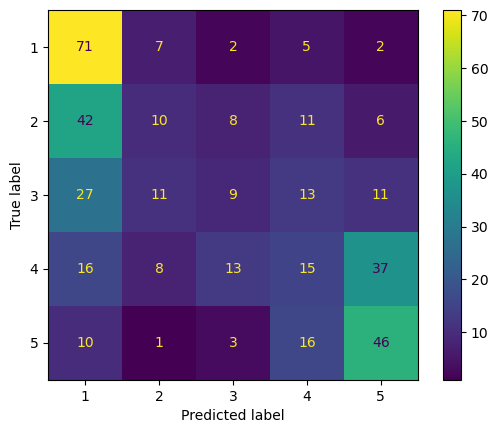

In [18]:
train_multimodal(X_train_m17[['abstract', 'label']], pd.DataFrame(X_test_m17['abstract']), y_test_m17, 'multiclass')


No path specified. Models will be saved in: "AutogluonModels\ag-20240616_171553"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240616_171553"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

Predicting: 0it [00:00, ?it/s]

'Task: Regression'

'Multimodal Predictor MAE score before roudning: 0.855'

'Multimodal Predictor Accuracy score: 0.395'

'Multimodal Predictor Recall score: 0.3931680055721887'

'Multimodal Predictor F1 score: 0.3892917975338523'

'Multimodal Predictor Precision score: 0.39014845990639513'

'Multimodal Predictor MAE score: 0.855'

'Multimodal Predictor MSE score: 1.465'

'Multimodal Predictor RMSE score: 1.2103718436910205'

None

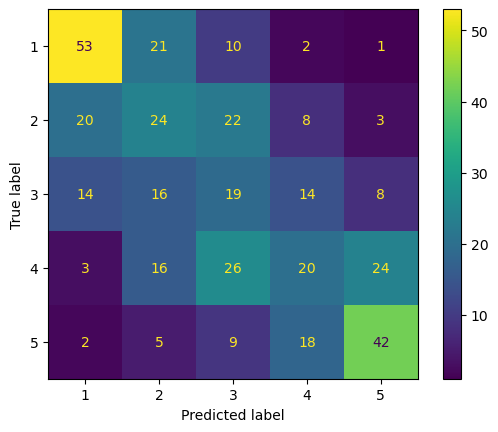

In [11]:
train_multimodal(X_train_m17, X_test_m17, y_test_m17, 'multiclass')

No path specified. Models will be saved in: "AutogluonModels\ag-20240616_172503"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240616_172503"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:     

Predicting: 0it [00:00, ?it/s]

'Task: Regression'

'Multimodal Predictor MAE score before roudning: 0.8748244374990464'

'Multimodal Predictor Accuracy score: 0.34'

'Multimodal Predictor Recall score: 0.33981637194305814'

'Multimodal Predictor F1 score: 0.3301989798681597'

'Multimodal Predictor Precision score: 0.4670208690392177'

'Multimodal Predictor MAE score: 0.835'

'Multimodal Predictor MSE score: 1.215'

'Multimodal Predictor RMSE score: 1.1022703842524302'

None

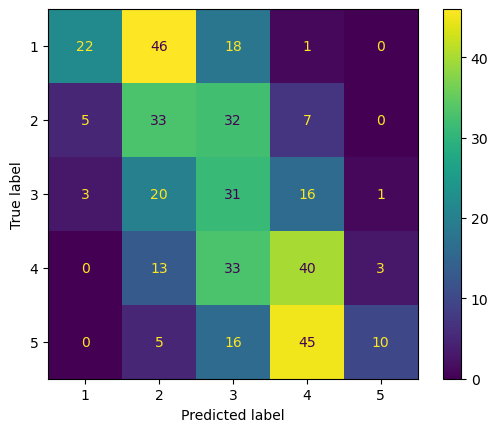

In [12]:
train_multimodal(X_train_m17, X_test_m17, y_test_m17, 'regression')

### Run Tabular

In [8]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240620_144309")

In [9]:
X_test_c19['label'] = y_test_c19

In [10]:
fi = predictor.feature_importance(X_test_c19)


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



abstract                      0.105333
biological_sciences           0.029000
title                         0.028333
basic_medicine                0.025667
rigor                         0.015000
chemical_sciences             0.011000
descriptive_research          0.009000
education                     0.004667
languages_and_literature      0.004667
sociology                     0.003333
computer_sciences             0.003333
qualitative_research          0.003000
industrial_biotechnology      0.003000
earth_and_related_sciences    0.002333
physical_sciences             0.002000
observation                   0.002000
Name: importance, dtype: float64

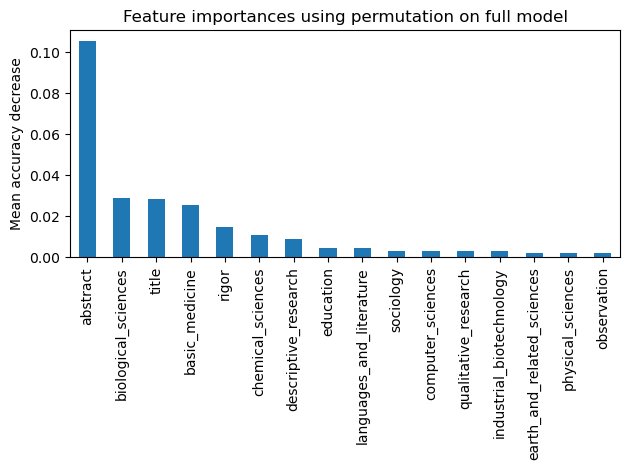

In [12]:
import matplotlib.pyplot as plt
importances = pd.Series(fi.importance, index=X_train_c19.columns)
importances = importances.sort_values(ascending=False)[:16]
display(importances)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [42]:
fi

,importance,stddev,p_value,n,p99_high,p99_low
abstract,0.105333,0.006390,0.000002,5,0.118491,0.092176
biological_sciences,0.029000,0.004503,0.000068,5,0.038272,0.019728
title,0.028333,0.010069,0.001630,5,0.049066,0.007601
basic_medicine,0.025667,0.005349,0.000214,5,0.036680,0.014653
rigor,0.015000,0.004082,0.000598,5,0.023406,0.006594
...,...,...,...,...,...,...
chemical_engineering,-0.002000,0.001826,0.964758,5,0.001759,-0.005759
other_engineering_and_technologies,-0.002667,0.000913,0.998581,5,-0.000787,-0.004546
civil_engineering,-0.002667,0.000913,0.998581,5,-0.000787,-0.004546
other_social_sciences,-0.003000,0.000745,0.999578,5,-0.001465,-0.004535


In [12]:
X_test_c19

,title,abstract,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,physical_sciences,...,focus_groups,interviews,mixed_methods,observation,qualitative_research,quantitative_research,questionnaires,secondary_research,survey_methodology,label
1451,To What Extent Can Digitally-Mediated Team Com...,Digital communication technologies can be used...,1.0,1.0,0,1,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1842,The Association of Cardiovascular Diseases and...,Coronavirus disease 2019 (COVID-19) has become...,1.0,2.0,0,0,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
798,How to Train Your Dragon: Harnessing Gamma Del...,The emergence of viruses with pandemic potenti...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,0
997,COVID‐19 vaccine hesitancy and attitudes in Qa...,BACKGROUND: Vaccine hesitancy is a global thre...,1.0,1.0,0,1,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1791,Coronavirus: Older Persons With Cancer in Ital...,Italy is the European country that was hit fir...,1.0,2.0,0,1,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,Machine-Actionable Data Management Plans: A Kn...,Funding bodies and other policy-makers are inc...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,1,0,0,0,0
435,Early Detection of Diabetic Peripheral Neuropa...,Diabetic peripheral neuropathy (DPN) is the mo...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,0
599,Elective cardiovascular care in the era of the...,The COVID-19 pandemic has led to significant m...,1.0,1.0,0,0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2310,Real-Time Digital Contact Tracing: Development...,BACKGROUND: Severe acute respiratory syndrome ...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,0,1,0,0,0,1


In [13]:
X_train_c19

,title,abstract,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,physical_sciences,...,focus_groups,interviews,mixed_methods,observation,qualitative_research,quantitative_research,questionnaires,secondary_research,survey_methodology,label
545,Educational gains of in‐person vs. distance le...,Using data from a computer‐based formative fee...,2.0,2.0,0,1,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
624,Emetine suppresses SARS-CoV-2 replication by i...,Emetine is a FDA-approved drug for the treatme...,2.0,2.0,0,1,2.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2739,Gynecological laparoscopic surgery in the shad...,A global public health problem with a high rat...,1.0,0.0,0,0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2786,Infections on the move: how transient phases o...,Animal movement impacts the spread of human an...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,1
394,A New Method of Differentiation Between a Biol...,The main obstacle in identifying a biological ...,1.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,Impacts of SARS on health-seeking behaviors in...,BACKGROUND. The severe acute respiratory syndr...,1.0,2.0,0,1,2.0,1.0,1.0,1.0,...,0,0,1,0,1,0,0,0,1,1
2078,Exercise-induced immune system response: Anti-...,Abstract A wide array of molecular pathways ha...,1.0,2.0,0,1,2.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
890,SOFIA(®)RSV: prospective laboratory evaluation...,BACKGROUND: Respiratory syncytial virus (RSV) ...,2.0,2.0,0,1,2.0,0.0,0.0,0.0,...,0,0,1,0,1,1,0,0,0,0
2517,Rapid response in the COVID-19 pandemic: a Del...,BACKGROUND: COVID-19 was declared a global hea...,2.0,2.0,0,1,2.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,1


In [7]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240616_171553")
X_test_m17['label'] = y_test_m17
fi_m17 = predictor.feature_importance(X_test_m17)

These features in provided data are not utilized by the predictor and will be ignored: ['focus_groups']

Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

	7776.07s	= Expected runtime (1555.21s per shuffle set)
Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

Load pretrained checkpoint: C:\Users\vojta\OneDrive\Skola\bachelor-thesis\AutogluonModels\ag-20240616_171553\models\MultiModalPredictor\automm_model\model.ckpt


Predicting: 0it [00:00, ?it/s]

	862.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [8]:
fi_m17

,importance,stddev,p_value,n,p99_high,p99_low
abstract,0.1745,0.023278,0.000037,5,0.222430,0.126570
basic_medicine,0.0060,0.001369,0.000304,5,0.008819,0.003181
grammar,0.0060,0.002236,0.001941,5,0.010604,0.001396
animal_and_dairy_science,0.0060,0.002236,0.001941,5,0.010604,0.001396
earth_and_related_environmental_sciences,0.0045,0.001118,0.000422,5,0.006802,0.002198
...,...,...,...,...,...,...
replicability,-0.0020,0.002092,0.950350,5,0.002307,-0.006307
chemical_engineering,-0.0025,0.002500,0.955495,5,0.002648,-0.007648
electrical_engineering,-0.0025,0.001768,0.982945,5,0.001140,-0.006140
mechanical_engineering,-0.0030,0.003260,0.945650,5,0.003712,-0.009712


In [ ]:
import matplotlib.pyplot as plt
importances = pd.Series(fi.importance, index=X_train_m17.columns)
importances = importances.sort_values(ascending=False)[:16]
display(importances)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [21]:
predictor.feature_importance(X_test_c19, silent=False)

Computing feature importance via permutation shuffling for 64 features using 600 rows with 5 shuffle sets...
	244.03s	= Expected runtime (48.81s per shuffle set)

KeyboardInterrupt

